In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import librosa
from microphone import record_audio, play_audio

fs = 44100

In [2]:
def file_to_array(file_path):
    """  It transforms a song into a np array
    :param
        file_path[String]:
            A file path to the song
    :return:
        samples[np.array]:
            This is an array of the values of the song at the file path at a sampling rate of 44100 Hz.
    """
    samples, fs = librosa.load(file_path, sr = 44100, mono = True)
    return samples

In [3]:
Moonlight = file_to_array(r"/Users/reneegloger/Desktop/Moonlight_in_Vermont.mp3")

In [16]:
def mic_to_numpy_array(time):
    mic_input, fs= record_audio(time)
    a = []
    for i in mic_input:
        a.append(np.fromstring(i, dtype=np.int16))
    a = np.hstack(a)
    return a

In [7]:
def plot_spectogram(samples):
    """ It takes a sample of a song and plots the spectrogram of it.
    :param
        samples[np.array]:
            The array of samples of the song that was recorded or filed in.
    :return:
        Nothing
    """
    digital = np.copy(samples)
    fig, ax = plt.subplots()
    plt.show()
    S, f, t, im = ax.specgram(digital, NFFT=4096, Fs=fs, window=mlab.window_hanning, noverlap=(4096 // 2))
    fig.colorbar(im)

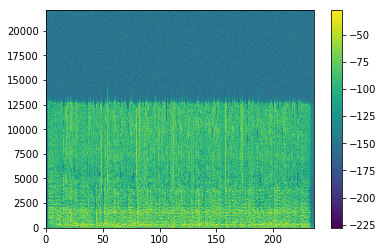

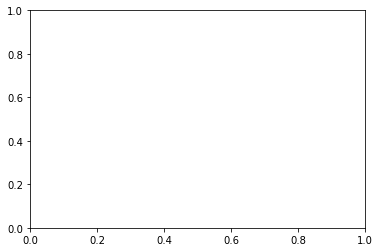

/Users/reneegloger/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7235: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


In [8]:
plot_spectogram(Moonlight)

In [ ]:
def spectogram(samples):
    """
    :param
        samples:
    :return:
        (S, f, t):
            This is a tuple of the spectrogram, the frequencies and the times.
        S:
            The 2D array of the coefficients of the DFT of the song. So S[i, j] is the coefficient at frequency = i
            and time = j.
        f:
    """

    digital = np.copy(samples)
    S, f, t = mlab.specgram(digital, NFFT=4096, Fs=fs, window=mlab.window_hanning, noverlap=(4096 // 2))
    to_return = (S, f, t)
    return to_return

In [18]:
def plot_song(samples):
    cutSamples = samples[::1000]
    # plt.plot(cutSamples)
    times = np.arange(len(samples))
    times = times / 44100
    cutTimes = times[::1000]
    fig, ax = plt.subplots()
    ax.plot(cutTimes, cutSamples)


In [19]:
def plot_dft(samples):
    dft = np.fft.rfft(samples)
    times = np.arange(len(samples))
    times = times / 44100
    cutDFT = dft[::1000]
    freq = np.arange(len(dft)) / times[-1]
    cutFreq = freq[::1000]
    fig, ax = plt.subplots()
    ax.plot(cutFreq, np.abs(cutDFT))
    ax.set_xlabel("Frequencies(Hz)")


In [9]:
song = mic_to_numpy_array(2)
plot_spectogram(song)

NameError: name 'mic_to_numpy_array' is not defined

In [11]:
#--------------------------------------------------------------------------------------------------------------------

In [15]:
song_database = {}
fan = 20

In [26]:
def add_song_to_dict(peaks, songTitle):
    """
    adds a song to a databse by anazlyzing the difference in time between the change in frequencies
    song ex:
        keys: (f1,f2,t2-t1), (f1,f3,t3-t1), ... (f1,f(1+freqfan), t(1+freqfan)-t1)
              (f2,f3,t3-t2), (f2,f4,t4-t2), ... (f2,f(2+freqfan), t(2+freqfan)-t2)
              ...
              
        stored for each key: ("title",diff from t1 to beg of mic audio)
    ------------------------------------------------------------------------------------------------
    
    paramaters:
        peaks: 2D array of Nx2: List of each song's peaks incuding the (freq and time-stamp)
        songTitle: str of songTitle
        
    returns:
        adds to dictionary all of the keys and a tuple of (their respective song title, t1)
    """
    #pickling - fast way for python to save dictionaries
    for peakStartIndex in range(len(peaks)):
        referencePeak = peaks[peakStartIndex]
        f1 = referencePeak[0]
        t1 = referencePeak[1]
        
        #get the slice of fan:
        if peakStartIndex + fan > len(peaks[peakStartIndex+1:]):
            peak_slice = peaks[peakStartIndex+1:]
        else:
            peak_slice = peaks[peakStartIndex+1:peakStartIndex+fan]
        
        
        
        for peak in peak_slice:
            #what happens if you reach the end!!!! include if statement
            f2 = peak[0]
            t2 = peak[1]
            #check key
            key = (f1,f2,t2-t1)
            if not(key in song_database):
                song_database[key] = []
            
            song_database[key].append((songTitle,t1))
            #include another dict for the a new dict for new song nd compare
    

In [27]:
#peasks[0] = (freq,time)
peaksIn = [(100,1),(125,2),(100,5),(300,6)]
songNameIn = "dill"

In [28]:
add_song_to_dict(peaksIn,songNameIn)

In [31]:
print(song_database)

{(100, 125, 1): [('dill', 1)], (100, 100, 4): [('dill', 1)], (100, 300, 5): [('dill', 1)], (125, 100, 3): [('dill', 2)], (125, 300, 4): [('dill', 2)], (100, 300, 1): [('dill', 5)]}


In [121]:
def check_database(MicPeaks):
    #!!!!TRY DOING PERCENTAES AND NORMAILIZATION FOR SPED UP SONGS AND HIGHER KEY
    """
        First calculates time differences between peaks of input
        
        Compares the peak distributions of the Mic input to that of the dictionary
        Calls the keys created by the Mic peaks, and searches the database for matching keys
        Creates a new dictionary and for every match, it will enter the same key and enter the tuple: (Song title, T(song) - T(MicInput))
        Checks the dictionarry with Counter() to fnd the greatest number of standardized matches
    ------------------------------------------------------------------------------------------------
    
    paramaters:
        MicPeaks: 2D array of Nx2: List of Mic song's peaks incuding the (freq and time-stamp)
        
    returns:
        New dictionary of common keys, including the tuple mentioned above^
        The greatest number of matching bins using Counter() - possibly include a confidence percentage by ranking greatest retyrns, and checking appropriate confidences
    """
    #1)
    referencePeak = MicPeaks[0]
    f1 = referencePeak[0]
    t1 = referencePeak[1]
    MicKeyList = []
    for peak in MicPeaks[1:]:
        f2 = peak[0]
        t2 = peak[1]
        key = (f1, f2, t2 - t1)
            
        MicKeyList.append(key)
     
    
    #2)
    
    CommonKeys = []
    #checks for MicKeys in song_database_dict 
    #   if there is, record tuple: ("Song Title" of match, T(song) - t1 (aka ref[1]))
    
    for key in MicKeyList:
        if key in song_database:
            #Its a match!
            #print(len(song_database[key][0]))
            
            
            #if length of song_database[key] > 1, do a loop
            if(len(song_database[key][0])>1):
                for match in song_database[key]:
                    songMatchTitle = match[0]
                    songT1Ref = match[1]
                    CommonKeys.append((songMatchTitle, t1 -songT1Ref)) 
            else:
                songMatchTitle = song_database[key][0]
                songT1Ref = song_database[key][1]
                CommonKeys.append((songMatchTitle, t1 -songT1Ref)) 
            
    #return CommonKeys
    print("CommonKeys:")
    print(CommonKeys)
    print("\n")
    #4)
    
    #create ANOTHER dict for all matches
    MatchCount = {}
    
    for match in CommonKeys:
        if match in MatchCount:
            MatchCount[match] += 1
        else:
            MatchCount[match] = 1
            
    
    #rank count the total matches, and find the biggest match -> calc song & calc percentage
    totalMatches = 0
    #print(MatchCount[0])
    biggestMatch = list(MatchCount)[0]
    for match in MatchCount:
        currentVal = MatchCount[match]
        if(currentVal > MatchCount[biggestMatch]):
            biggestMatch = match
        totalMatches += currentVal 
    
    
    percentConfidence = MatchCount[biggestMatch] / totalMatches
    return (biggestMatch[0], percentConfidence)
    
    

In [122]:
peaksMicIn = [(100,2),(125,3),(300,7)]

In [123]:
check_database(peaksMicIn)

CommonKeys:
[('dill', 1), ('dill', 1)]




('dill', 1.0)

In [63]:
temp = ["a","b","c","b","c","d","d","d","d","d","d"]

In [71]:
temp[0]


'a'

In [101]:
temp2 = {"a":4,"b":44}

list(temp2)

['a', 'b']